# Songs Popularity Prediction

## Obiettivo 
L'obiettivo di questo progetto è la creazione di un modello in grado di predire la popolarità di una canzone sulla base di alcuni suoi parametri, quali il genere, la durata e l'anno di uscita, e sulla base di alcuni parametri che riguardano l'artista che l'ha creata. 

## Dataset
L'idea per il progetto è nata da questo dataset trovato su Kaggle a questo indirizzo https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023, il quale contiene dati sulle 100 canzoni più popolari per ogni anno dal 2000 al 2023, per un totale di 2385 record.

Abbiamo poi deciso di integrare questo dataset di base con altre canzoni prese da varie playlist di Spotify, così da impedire che potenziali *bias* presenti nel dataset di partenza incidano negativamente sull'efficacia delle predizioni.

## Implementazione

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Descrizione features

Carichiamo il dataset di Kaggle dal file csv e mostriamone le prime righe.

In [209]:
songs = pd.read_csv("kaggle_songs.csv", sep=";")
songs.head(10)

title          artist  \
0                                 Flowers     Miley Cyrus   
1                       Cupid - Twin Ver.     FIFTY FIFTY   
2                                    BESO         ROSALÍA   
3                      Boy's a liar Pt. 2  PinkPantheress   
4  Creepin' (with The Weeknd & 21 Savage)    Metro Boomin   
5                                Daylight   David Kushner   
6                                     TQG         KAROL G   
7           Calm Down (with Selena Gomez)            Rema   
8                               Anti-Hero    Taylor Swift   
9                            Here With Me            d4vd   

                 top genre  year  bpm  energy  danceability   dB  liveness  \
0                      pop  2023  118      68             71  -4         3   
1         k-pop girl group  2023  120      59             78  -8        35   
2                      pop  2023   95      64             77  -7        17   
3              bronx drill  2023  133      81             70  -8        25   
4                      rap  2022   98      62             72  -6         8   
5  gen z singer-songwriter  2023  130      43             51  -9         9   
6                reggaeton  2023  180      63             72  -4         9   
7                afrobeats  2022  107      81             80  -5        11   
8                      pop  2022   97      64             64  -7        14   
9              bedroom pop  2022  132      47             57  -8        13   

   valence  duration  acousticness  speechiness   popularity  
0       65       200             6             7          98  
1       73       174            44             3          97  
2       53       195            74            14          96  
3       86       131            25             5          96  
4       17       222            42             5          96  
5       32       213            83             3          96  
6       61       199            67            28          96  
7       80       239            38             4          95  
8       53       201            13             5          94  
9       29       242            53             3          94

Si osservi che i record del dataset sono già ordinati per popolarità decrescente.

Notare inoltre come sia stato usato un indice numerico generato automaticamente da pandas, poiché nessun insieme di attributi può costituire una chiave primaria in questo dataset: il titolo non può esserlo perché due canzoni diverse possono ovviamente condividere lo stesso titolo, ma anche la coppia (titolo, artista) non funziona in quanto una canzone può essere rilasciata più volte (in linea teorica anche durante lo stesso anno, per quanto molto improbabile).

Questa è la descrizione del significato delle variabili data dal sito http://organizeyourmusic.playlistmachinery.com/ utilizzato dal creatore del dataset:
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general madness, sometimes the release years are not what you'd expect.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energetic the song is.
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Length - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song *currently* is.
- Duration - The length of the song.

La definizione di alcune variabili, come _energy_, _danceability_, _valence_ e _popularity_, appare piuttosto vaga e soggettiva. In assenza di dettagli su come sono calcolate, sarà necessario considerarne i valori per avere una idea più precisa del significato.

Nel nome delle colonne *speechiness* e *danceability* è presente uno spazio di troppo, che va rimosso.

In [210]:
songs.columns = songs.columns.str.replace('speechiness ', 'speechiness').str.replace('danceability ', 'danceability')

Aggiungiamo ora le canzoni delle altre playlist.

In [211]:
naughts = pd.read_csv("2000s.csv", sep=",")
tens = pd.read_csv("2010s.csv", sep=",")
twenties = pd.read_csv("2020s.csv", sep=",")
now = pd.read_csv("now.csv", sep=",")

new_songs = pd.concat([naughts, tens, twenties, now])

In [212]:
new_songs.drop(labels=["Unnamed: 0", "sel", "Unnamed: 2", "added"], axis=1, inplace=True)
new_songs = new_songs[new_songs["top genre"] != "uk drill"]
new_songs.dropna(axis=0, how="any", inplace=True)
new_songs.columns = songs.columns

In [213]:
new_songs["bpm"] = new_songs["bpm"].map(lambda elem: int(elem))
new_songs["energy"] = new_songs["energy"].map(lambda elem: int(elem))
new_songs["danceability"] = new_songs["danceability"].map(lambda elem: int(elem))
new_songs["dB"] = new_songs["dB"].map(lambda elem: int(elem))
new_songs["liveness"] = new_songs["liveness"].map(lambda elem: int(elem))
new_songs["valence"] = new_songs["valence"].map(lambda elem: int(elem))
new_songs["acousticness"] = new_songs["acousticness"].map(lambda elem: int(elem))
new_songs["speechiness"] = new_songs["speechiness"].map(lambda elem: int(elem))

In [214]:
new_songs

title       artist            top genre  year  \
0                              Yellow     Coldplay       permanent wave  2000   
1                          Without Me       Eminem      detroit hip hop  2002   
2                 The Real Slim Shady       Eminem      detroit hip hop  2000   
3                          In the End  Linkin Park    alternative metal  2000   
4                       The Scientist     Coldplay       permanent wave  2002   
...                               ...          ...                  ...   ...   
2292                      La Vecinita       Vico C        latin hip hop  2018   
2295                    Yo Te Pidere'    Los Reyes  northern irish punk  2018   
2304                     Rumba Habana   DJ Sanny J          italo dance  2018   
2311             El Doctorado - Remix    Tony Dize            reggaeton  2019   
2315  Black Friday II (feat. J. Cole)  Black Hippy  underground hip hop  2020   

      bpm  energy  danceability  dB  liveness  valence duration  acousticness  \
0     173      66            43  -7        23       28      267             0   
1     112      67            91  -3        24       66      290             0   
2     105      66            95  -4         5       76      284             3   
3     105      86            56  -6        21       40      217             1   
4     146      44            56  -7        11       21      310            73   
...   ...     ...           ...  ..       ...      ...      ...           ...   
2292   94      64            93  -6         6       85      266             8   
2295  118      89            64  -7         5       73      182            15   
2304  127      87            82  -5         6       77      396             2   
2311  120      71            74  -7        29       74      265            15   
2315   95      71            58  -8        25       59      428            21   

      speechiness  popularity  
0               3          93  
1               7          91  
2               6          90  
3               6          89  
4               2          88  
...           ...         ...  
2292           26           0  
2295            4           0  
2304           12           0  
2311            5           0  
2315           47           0  

[9067 rows x 14 columns]

In [215]:
# convert into float from string type for duration
for i, duration in enumerate(new_songs["duration"]):
    if type(duration) == str:
        new_songs["duration"][i] = float(duration.replace(",", "."))
    else:
        new_songs["duration"][i] = duration



C:\Users\Utente\AppData\Local\Temp\ipykernel_18464\573571585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_songs["duration"][i] = float(duration.replace(",", "."))


C:\Users\Utente\AppData\Local\Temp\ipykernel_18464\573571585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_songs["duration"][i] = float(duration.replace(",", "."))
C:\Users\Utente\AppData\Local\Temp\ipykernel_18464\573571585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_songs["duration"][i] = float(duration.replace(",", "."))
C:\Users\Utente\AppData\Local\Temp\ipykernel_18464\573571585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [216]:
new_songs = new_songs.reset_index(drop=True)

In [217]:
songs = pd.concat([songs, new_songs])

In [218]:
for song in songs["duration"]:
	if type(song) == str:
		songs["duration"] = songs["duration"].map(lambda elem: float(elem))
		

In [219]:
# change the songs duration dtype to float
songs["duration"] = songs["duration"].astype(float)



### Analisi esplorativa

Dividiamo le feature in testuali e numeriche.

In [220]:
string_columns = songs.select_dtypes(include=["object"]).columns
numeric_columns = songs.select_dtypes(include=["number"]).columns

In [221]:
print("String columns: ", list(string_columns))
print("Numeric columns: ", list(numeric_columns))

String columns:  ['title', 'artist', 'top genre']
Numeric columns:  ['year', 'bpm', 'energy', 'danceability', 'dB', 'liveness', 'valence', 'duration', 'acousticness', 'speechiness', 'popularity']


Con la funzione **describe** otteniamo una prima visualizzazione numerica della distribuzione dei dati all'interno del dataset.

In [222]:
songs.describe()

year           bpm        energy  danceability            dB  \
count  11452.000000  11452.000000  11452.000000  11452.000000  11452.000000   
mean    2013.118058    122.278030     70.844831     64.315753     -6.215246   
std        6.541607     27.462165     18.268013     16.063173      2.691750   
min     1985.000000     52.000000      4.000000      9.000000    -25.000000   
25%     2008.000000    100.000000     59.000000     54.000000     -7.000000   
50%     2015.000000    123.000000     73.000000     66.000000     -6.000000   
75%     2018.000000    139.000000     85.000000     76.000000     -4.000000   
max     2023.000000    236.000000    100.000000     99.000000      0.000000   

           liveness       valence      duration  acousticness   speechiness  \
count  11452.000000  11452.000000  11452.000000  11452.000000  11452.000000   
mean      18.630545     51.824048    234.706592     17.088194     10.979654   
std       14.581849     23.390797     52.908030     22.520569     10.699883   
min        1.000000      3.000000      1.027000      0.000000      2.000000   
25%        9.000000     34.000000    203.000000      1.000000      4.000000   
50%       13.000000     52.000000    229.000000      7.000000      6.000000   
75%       24.000000     70.000000    259.000000     25.000000     13.000000   
max       97.000000     98.000000    726.000000     99.000000     88.000000   

         popularity  
count  11452.000000  
mean      58.817848  
std       18.508337  
min        0.000000  
25%       48.000000  
50%       62.000000  
75%       73.000000  
max       98.000000

Vediamo come molte variabili, tra cui la label _popularity_, abbiano valori verosimilmente compresi tra 0 e 100. 

Notiamo poi come l'anno di pubblicazione meno recente sia il 1985. Non si tratta necessariamente di un errore nei dati, in quanto il dataset contiene le canzoni più _popolari_ per ogni anno dal 2000 al 2023, ma chiaramente la data di uscita delle canzoni non è limitata a questo periodo. Tuttavia, si è deciso di rimuovere tutte le canzoni precedenti all'anno 2000, che rappresentano outlier.

In [223]:
songs = songs[songs["year"] >= 2000]
songs = songs.reset_index(drop=True)
songs

title          artist  \
0                                     Flowers     Miley Cyrus   
1                           Cupid - Twin Ver.     FIFTY FIFTY   
2                                        BESO         ROSALÍA   
3                          Boy's a liar Pt. 2  PinkPantheress   
4      Creepin' (with The Weeknd & 21 Savage)    Metro Boomin   
...                                       ...             ...   
11400                             La Vecinita          Vico C   
11401                           Yo Te Pidere'       Los Reyes   
11402                            Rumba Habana      DJ Sanny J   
11403                    El Doctorado - Remix       Tony Dize   
11404         Black Friday II (feat. J. Cole)     Black Hippy   

                 top genre  year  bpm  energy  danceability  dB  liveness  \
0                      pop  2023  118      68            71  -4         3   
1         k-pop girl group  2023  120      59            78  -8        35   
2                      pop  2023   95      64            77  -7        17   
3              bronx drill  2023  133      81            70  -8        25   
4                      rap  2022   98      62            72  -6         8   
...                    ...   ...  ...     ...           ...  ..       ...   
11400        latin hip hop  2018   94      64            93  -6         6   
11401  northern irish punk  2018  118      89            64  -7         5   
11402          italo dance  2018  127      87            82  -5         6   
11403            reggaeton  2019  120      71            74  -7        29   
11404  underground hip hop  2020   95      71            58  -8        25   

       valence  duration  acousticness  speechiness  popularity  
0           65     200.0             6            7          98  
1           73     174.0            44            3          97  
2           53     195.0            74           14          96  
3           86     131.0            25            5          96  
4           17     222.0            42            5          96  
...        ...       ...           ...          ...         ...  
11400       85     293.0             8           26           0  
11401       73     261.0            15            4           0  
11402       77     375.0             2           12           0  
11403       74     255.0            15            5           0  
11404       59     201.0            21           47           0  

[11405 rows x 14 columns]

Andiamo ora più nel dettaglio e vediamo se esiste qualche correlazione rilevante tra le feature. La funzione **scatter_matrix** permette di ottenere una matrice nella quale ogni cella non diagonale contiene uno *scatter plot* di due feature (numeriche) del dataset. Nelle celle diagonali vengono invece mostrati gli istogrammi dei valori delle feature.

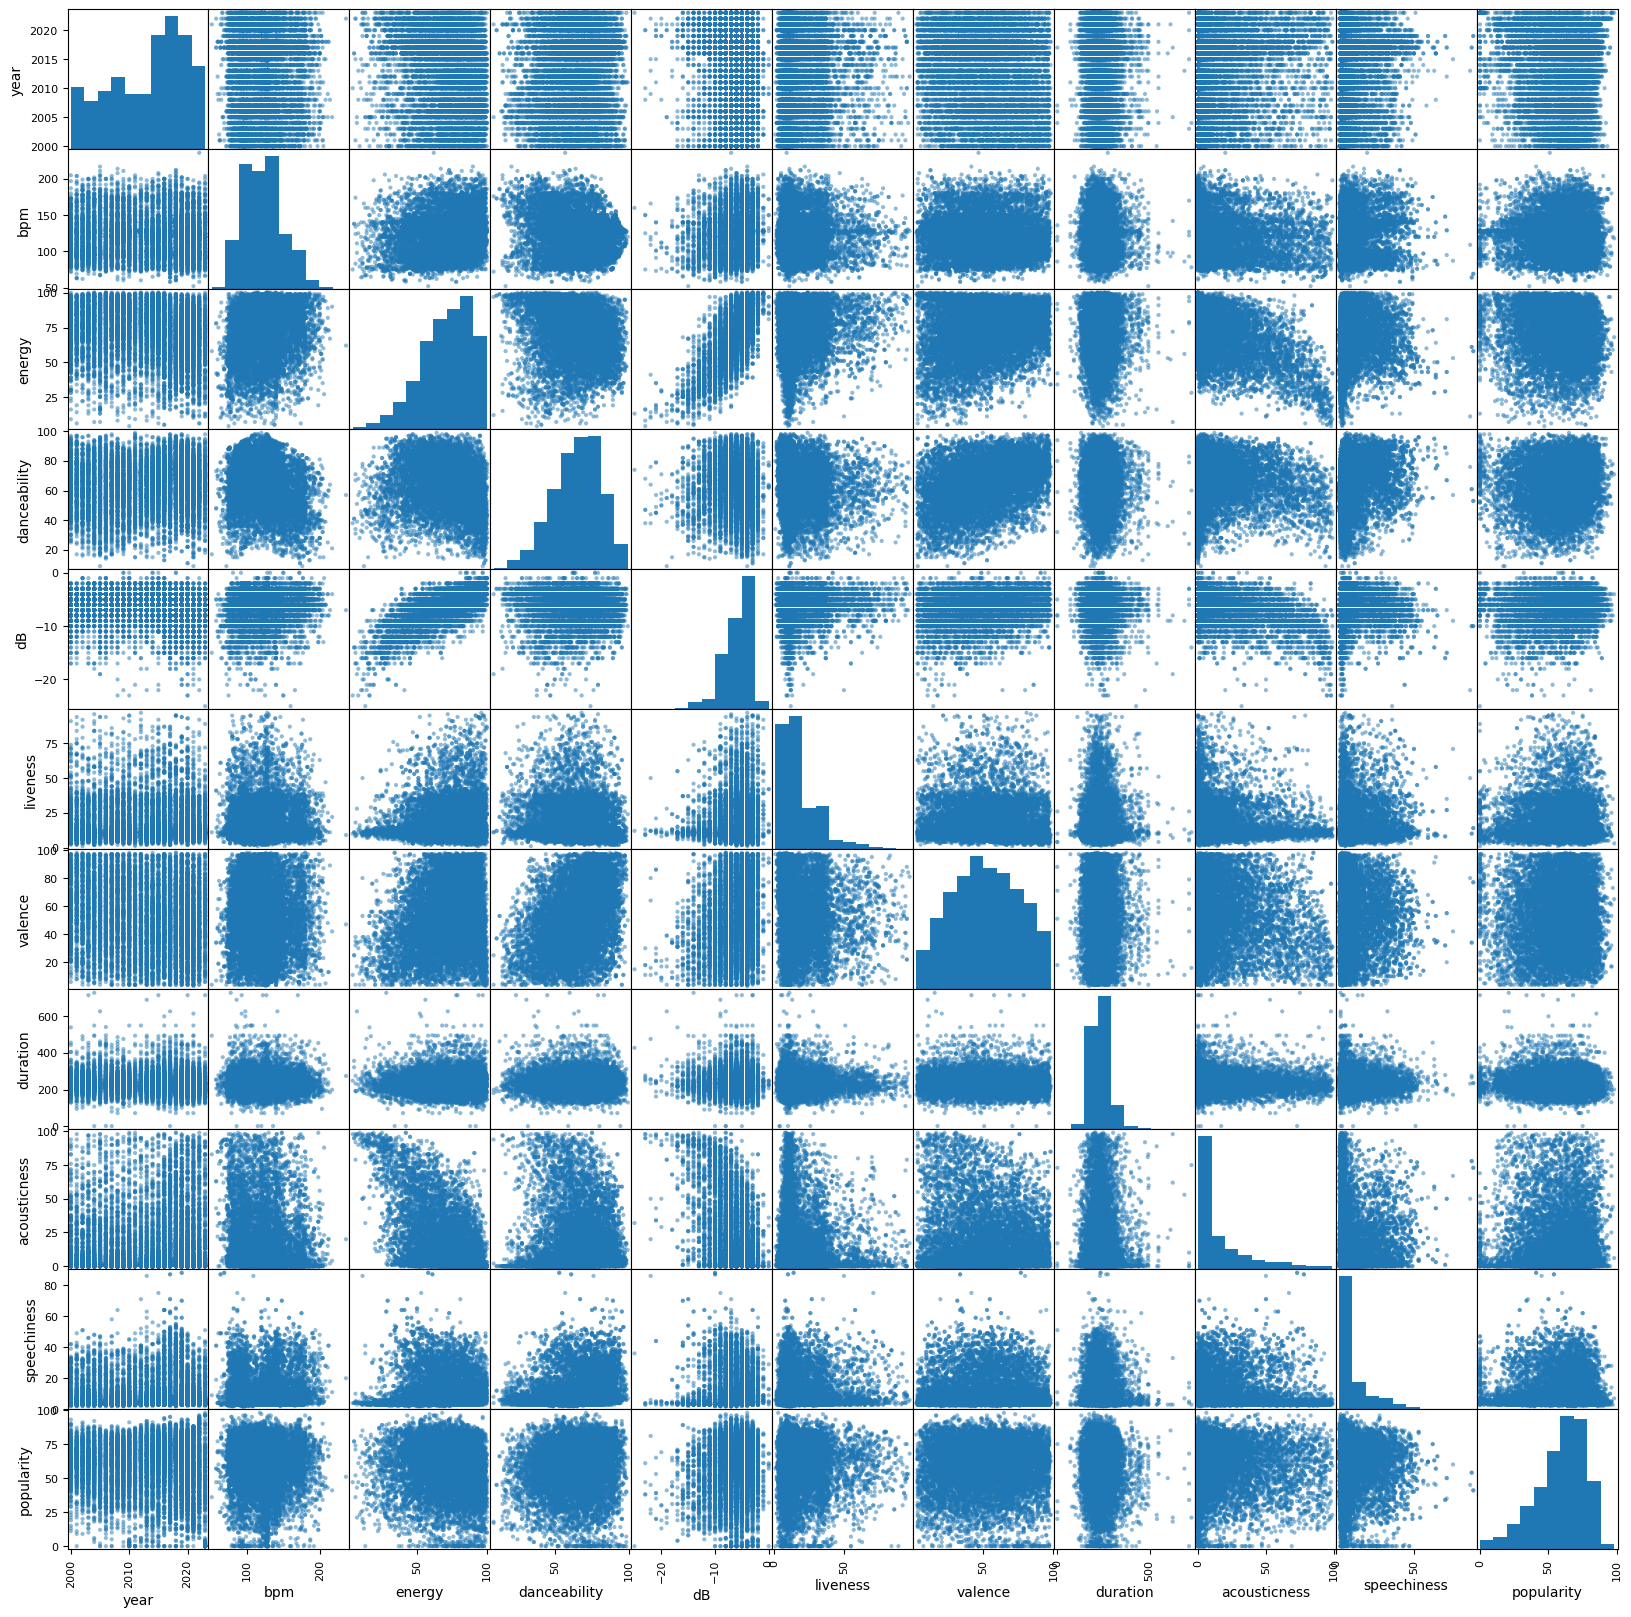

In [224]:
from pandas.plotting import scatter_matrix

scatter_matrix(songs[numeric_columns], figsize=(20, 20));

Osserviamo come ci sia una correlazione positiva tra anno di pubblicazione e popolarità attuale, proprio come ci si aspetterebbe. Un'altra correlazione positiva molto evidente è quella tra "energia" e intensità di volume in _dB_, anch'essa abbastanza ovvia.

Siccome molte correlazioni nel grafico precedente non appaiono chiare, utilizziamo la funzione **corr** dei DataFrame di **pandas** per creare una tabella a doppia entrata che mostri a livello numerico la correlazione tra una feature e ciascuna delle altre, secondo il *coefficiente di Pearson*.

<Figure size 2000x2000 with 0 Axes>

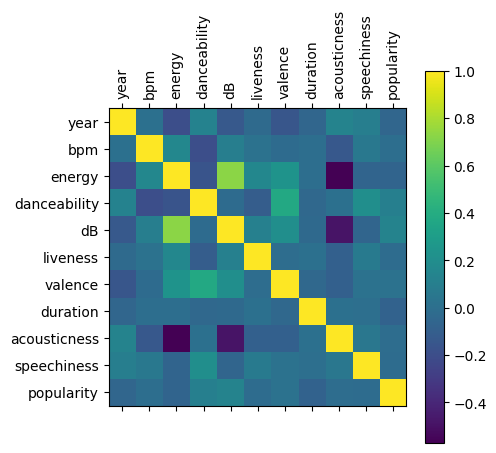

In [225]:
corr = songs.corr(numeric_only=True, method="pearson")
plt.figure(figsize=(20, 20))
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

Sorprendentemente, la popolarità di una canzone sembra correlata in maniera sensibile solo con l'anno di pubblicazione, e con nessuna delle caratteristiche intrinseche della canzone stessa, come ad esempio la sua energià, danzabilità e durata.

Ad ulteriore riprova, mostriamo la correlazione delle feature numeriche con la variabile _popularity_.

In [226]:
corr = songs[numeric_columns].corr()
corr["popularity"].sort_values(ascending=False)

popularity      1.000000
dB              0.131546
danceability    0.103752
valence         0.018634
bpm            -0.002545
acousticness   -0.011698
liveness       -0.013539
speechiness    -0.016424
year           -0.054291
energy         -0.068000
duration       -0.074743
Name: popularity, dtype: float64

Infine, vediamo la distribuzione di generi e artisti.

In [227]:
songs["top genre"].value_counts()

dance pop             819
alternative metal     529
atl hip hop           389
pop                   367
alternative rock      319
                     ... 
dutch metal             1
post-teen pop           1
swedish americana       1
progressive sludge      1
french hip hop          1
Name: top genre, Length: 798, dtype: int64

In [228]:
(songs["top genre"].value_counts() == 1).sum() / songs["top genre"].value_counts().count()

0.2706766917293233

I generi sono estremamente specifici, in quanto ci sono caratterizzazioni regionali all'interno di ciascun genere. Addirittura, il 36% di tutti i generi presenti nel dataset compare con una sola canzone.

In [229]:
songs["artist"].value_counts()

Kendrick Lamar      90
Kanye West          82
Drake               71
Calvin Harris       61
Rihanna             52
                    ..
John O'Callaghan     1
Ian van Dahl         1
Valentino Khan       1
Jauz                 1
Booba                1
Name: artist, Length: 3274, dtype: int64

In [230]:
songs["artist"].count() / songs["artist"].value_counts().count()

3.4835064141722665

Anche gli artisti sono molti rispetto al numero di canzoni totali. Mediamente, ogni artista è presente con 2.35 canzoni all'interno del dataset.

### Integrazione del dataset con altre fonti

#### NLP

Si è ritenuto necessario considerare per ogni canzone anche il suo testo, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di aiuto per predirne la popolarità.
Abbiamo dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Di seguito è possibile trovare il codice (commentato) che implementa questa operazione. Si noti tuttavia che l'esecuzione richede molto tempo (almeno un'ora), in quanto le richieste vanno spesso in timeout. Non è comunque necessario eseguire le celle seguenti, in quanto i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [231]:
# %pip install lyricsgenius
# import lyricsgenius as lg

In [232]:
import csv

"""
access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
genius = lg.Genius(access_token)

def get_lyrics(song_title, artist_name):
    song = genius.search_song(song_title, artist_name)
    return song.lyrics if song is not None else ""

songs = pd.read_csv("songs.csv", sep=";")

with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["title", "artist", "lyrics"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                lyrics = get_lyrics(song.title, song.artist)
                is_ok = True
                writer.writerow([song.title, song.artist, lyrics])
            except Exception as e:
                continue
""";

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [233]:
songs_lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
songs_lyrics

title               artist  \
0                                    Flowers          Miley Cyrus   
1                          Cupid - Twin Ver.          FIFTY FIFTY   
2                                       BESO              ROSALÍA   
3                         Boy's a liar Pt. 2       PinkPantheress   
4     Creepin' (with The Weeknd & 21 Savage)         Metro Boomin   
...                                      ...                  ...   
2380                              Southbound           Beach Blvd   
2381     Dance with Somebody - Radio Version           Mando Diao   
2382                                    Flow      Desire Machines   
2383                      Scared of the Dark  Everything Brighter   
2384                                   Sorry                LEADR   

                                                 lyrics  
0     88 ContributorsTranslationsEspañolPortuguêsKis...  
1     1 ContributorTranslationsEnglishBahasa MelayuF...  
2     29 ContributorsTranslationsPortuguêsEnglishDeu...  
3     92 ContributorsTranslationsPortuguêsTürkçeDeut...  
4     2 ContributorsNew Music Friday 12/02/22 Lyrics...  
...                                                 ...  
2380  2 ContributorsMe & My Skate Lyrics[Skit]\r\nOh...  
2381  1 ContributorDance With Somebody - Radio Versi...  
2382  1 ContributorWhat Matters? Lyrics[Hook]\r\nLea...  
2383  1 ContributorWay Home LyricsYa Ya Ya\r\n\r\nI ...  
2384  5 ContributorsI&I Lyrics[Intro]\r\nSelah\r\nKn...  

[2385 rows x 3 columns]

Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [234]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 54 canzoni di cui non è stato trovato il testo.


title             artist  \
16    Until I Found You (with Em Beihold) - Em Beiho...    Stephen Sanchez   
317                      Happy - From "Despicable Me 2"  Pharrell Williams   
339   Moves Like Jagger - Studio Recording From "The...           Maroon 5   
446   CAN'T STOP THE FEELING! (from DreamWorks Anima...  Justin Timberlake   
684   Valerie (feat. Amy Winehouse) - Version Revisited        Mark Ronson   
686   Waka Waka (This Time for Africa) [The Official...            Shakira   
905   Free Fallin' - Live at the Nokia Theatre Los A...         John Mayer   
912                                               Intro             The xx   
947   Summertime Sadness (Lana Del Rey Vs. Cedric Ge...       Lana Del Rey   
1086  Jenny from the Block (feat. Jadakiss & Styles ...     Jennifer Lopez   

     lyrics  
16           
317          
339          
446          
684          
686          
905          
912          
947          
1086

In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [235]:
songs_lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\r\nWe were good, we were gold\r\nKinda dream that can't be sold\r\nWe were right 'til we weren't\r\nBuilt a home and watched it burn\r\n\r\n[Pre-Chorus]\r\nMm, I didn't wanna leave you, I didn't wanna lie\r\nStarted to cry, but then remembered I\r\n\r\n[Chorus]\r\nI can buy myself flowers\r\nWrite my name in the sand\r\nTalk to myself for hours\r\nSay things you don't understand\r\nI can take myself dancing\r\nAnd I can hold my own hand\r\nYeah, I can love me better than you can\r\n\r\n[Post-Chorus]\r\nCan love me better, I can love me better, baby\r\nCan love me better, I can love me better, baby\r\n\r\n[Verse 2]\r\nPaint my nails cherry-red\r\nMatch the roses that you left\r\nNo remorse, no regret\r\nI forgive every word you said\r\nYou might also like[Pre-Chorus]\r\nOoh, I didn't wanna leave you, b

Molti dei testi che hanno pochi "contributors" (meno di 20) sono sbagliati: la seguente funzione permette di rimuoverli, cioè di assegnare ad essi il valore stringa vuota (''). Inoltre, rimuove dai testi validi le parti di stringa che non corrispondono al reale testo della canzone. 

In [236]:
def clean_lyrics(text):
    if text != '':
        contributors, other = text.split("Contributor")
        text = other.split("Lyrics")[1].split("Embed")[0] if int(contributors) > 20 else ''
    return text

In [237]:
songs_lyrics["lyrics"] = songs_lyrics["lyrics"].map(clean_lyrics)

In [238]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 775 canzoni di cui non è stato trovato il testo.


title           artist lyrics
1                                   Cupid - Twin Ver.      FIFTY FIFTY       
4              Creepin' (with The Weeknd & 21 Savage)     Metro Boomin       
7                       Calm Down (with Selena Gomez)             Rema       
12                                Die For You - Remix       The Weeknd       
16  Until I Found You (with Em Beihold) - Em Beiho...  Stephen Sanchez       
29                          Unholy (feat. Kim Petras)        Sam Smith       
36                                         La Bachata    Manuel Turizo       
38                               lovely (with Khalid)    Billie Eilish       
46                                         Yandel 150           Yandel       
50                       Double Fantasy (with Future)       The Weeknd

Il numero di canzoni che non possiedono testo è aumentato significativamente. Purtroppo questo problema è dovuto alle risposte fornite dall'API di Genius, quindi non è risolvibile a meno di non utilizzare un'altra API.

A questo punto il dataset è pronto per essere processato. Importiamo quindi le librerie necessarie per il NLP.

In [239]:
%pip install nltk
import nltk

%pip install langdetect
from langdetect import detect

Note: you may need to restart the kernel to use updated packages.



Per prima cosa, aggiungiamo al DataFrame una colonna contenente la lingua in cui è cantata la canzone, utilizzando la funzione **detect** del package **langdetect**.

In [240]:
def detect_language(text):
    return detect(text) if text != '' else None

In [241]:
songs_lyrics["language"] = songs_lyrics["lyrics"].map(detect_language)
songs_lyrics

title               artist  \
0                                    Flowers          Miley Cyrus   
1                          Cupid - Twin Ver.          FIFTY FIFTY   
2                                       BESO              ROSALÍA   
3                         Boy's a liar Pt. 2       PinkPantheress   
4     Creepin' (with The Weeknd & 21 Savage)         Metro Boomin   
...                                      ...                  ...   
2380                              Southbound           Beach Blvd   
2381     Dance with Somebody - Radio Version           Mando Diao   
2382                                    Flow      Desire Machines   
2383                      Scared of the Dark  Everything Brighter   
2384                                   Sorry                LEADR   

                                                 lyrics language  
0     [Verse 1]\r\nWe were good, we were gold\r\nKin...       en  
1                                                           None  
2     [Letra de "BESO"]\r\n\r\n[Coro: ROSALÍA]\r\nYa...       es  
3     [Verse 1: PinkPantheress]\r\nTake a look insid...       en  
4                                                           None  
...                                                 ...      ...  
2380                                                        None  
2381                                                        None  
2382                                                        None  
2383                                                        None  
2384                                                        None  

[2385 rows x 4 columns]

Notare come le canzoni senza testo o il cui testo è stato precedentemente scartato a causa dei pochi "contributors" abbiano il valore **None** nella colonna **language**.

La distribuzione dei valori mostra come la stragrande maggioranza delle canzoni che possiedono un testo "valido" siano in lingua inglese. Questo è presumibilmente dovuto al fatto che Genius è un sito americano e quindi fruito prevalentemente da anglofoni.

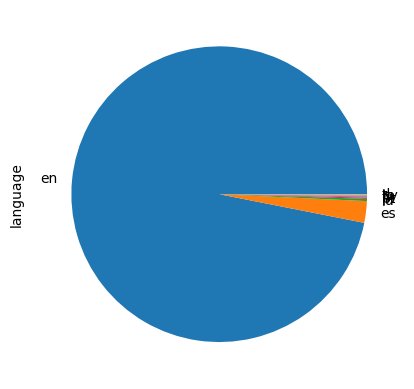

In [242]:
songs_lyrics["language"].value_counts().plot.pie();

Aggiungiamo al dataset la colonna _popularity_ presa dal dataset principale.

In [243]:
songs_lyrics["popularity"] = songs["popularity"]
songs_lyrics

title               artist  \
0                                    Flowers          Miley Cyrus   
1                          Cupid - Twin Ver.          FIFTY FIFTY   
2                                       BESO              ROSALÍA   
3                         Boy's a liar Pt. 2       PinkPantheress   
4     Creepin' (with The Weeknd & 21 Savage)         Metro Boomin   
...                                      ...                  ...   
2380                              Southbound           Beach Blvd   
2381     Dance with Somebody - Radio Version           Mando Diao   
2382                                    Flow      Desire Machines   
2383                      Scared of the Dark  Everything Brighter   
2384                                   Sorry                LEADR   

                                                 lyrics language  popularity  
0     [Verse 1]\r\nWe were good, we were gold\r\nKin...       en          98  
1                                                           None          97  
2     [Letra de "BESO"]\r\n\r\n[Coro: ROSALÍA]\r\nYa...       es          96  
3     [Verse 1: PinkPantheress]\r\nTake a look insid...       en          96  
4                                                           None          96  
...                                                 ...      ...         ...  
2380                                                        None          84  
2381                                                        None          84  
2382                                                        None          84  
2383                                                        None          84  
2384                                                        None          84  

[2385 rows x 5 columns]

Creiamo ora un dataset che contenga solo le canzoni con testo valido, da usare nell'addestramento e nella validazione di modelli predittivi che facciano uso di tecniche di NLP.

In [244]:
valid_songs_lyrics = songs_lyrics[songs_lyrics["lyrics"] != '']
valid_songs_lyrics

title          artist  \
0                Flowers     Miley Cyrus   
2                   BESO         ROSALÍA   
3     Boy's a liar Pt. 2  PinkPantheress   
5               Daylight   David Kushner   
6                    TQG         KAROL G   
...                  ...             ...   
2349    Lips Of An Angel          Hinder   
2351             Fake It         Seether   
2355              Switch      Will Smith   
2361    The Selfish Gene    Marlon Percy   
2368       One More Hero       Ekat Bork   

                                                 lyrics language  popularity  
0     [Verse 1]\r\nWe were good, we were gold\r\nKin...       en          98  
2     [Letra de "BESO"]\r\n\r\n[Coro: ROSALÍA]\r\nYa...       es          96  
3     [Verse 1: PinkPantheress]\r\nTake a look insid...       en          96  
5     [Verse 1]\r\nTelling myself I won't go there\r...       en          96  
6     [Letra de "TQG"]\r\n\r\n[Intro: KAROL G]\r\nLa...       es          96  
...                                                 ...      ...         ...  
2349  [Verse 1]\r\nHoney, why you callin’ me so late...       en          88  
2351  [Verse 1]\r\nWho's to know if your soul will f...       en          87  
2355  [Intro]\r\nYo mic check, mic check, yeah here ...       en          86  
2361  5/1\r\n11:11 - "Me, Chanel & Jameson"\r\nAazar...       en          85  
2368  [Verse 1: Loyle Carner]\r\nShe could be my lit...       en          85  

[1610 rows x 5 columns]

Costruiamo un semplice modello di tipo Bag of Words, così da avere una prima idea approssimativa di quanto la presenza di parole ricorrenti all'interno del testo di una canzone ne influenzi la popolarità. Facendo uso di un'istanza di **CountVectorizer**, possiamo creare una matrice testi-parole, nella quale ogni riga rappresenta una canzone e ogni colonna una parola che compare in almeno 15 canzoni. Questa soglia minima è stata aggiunta così da ridurre la dimensionalità dello spazio vettoriale. Inoltre, vengono anche rimosse le cosiddette _stopwords_ dai testi in lingua inglese.

Sulla matrice così creata viene effettuata una somma sulle colonne, il cui risultato è un vettore che associa ad ogni canzone la quantità di parole comuni che compaiono nel suo testo.

In [245]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=15, stop_words="english")
mat = cvect.fit_transform(valid_songs_lyrics["lyrics"])
lyric_popularity = mat.toarray().sum(axis=1)

In [246]:
np.corrcoef(lyric_popularity, valid_songs_lyrics["popularity"])

array([[ 1.        , -0.15209792],
       [-0.15209792,  1.        ]])

Questo risultato mostra come sia presente una leggera correlazione negativa tra il vettore contenente le "popolarità dei testi" e quello contenente i valori di popolarità delle canzoni. Si tratta di un risultato certamente interessante, ma sarebbe sbagliato trarre la conclusione che un testo "banale" implica una minor popolarità della canzone.

In effetti, si è scelto di non includere per nulla questa feature nel dataset principale, sia perché i suoi valori dipendono fortemente da quali canzoni fanno parte del dataset in uso, sia per la difficoltà di gestire le canzoni che non hanno testo.

Si è quindi deciso di provare a cercare un insieme di termini _significativi_, ovvero parole la cui presenza influenzi positivamente o negativamente la popolarità della canzone. Per fare ciò, si è fatto uso di un modello di regressione con regolarizzazione **LASSO**, in modo tale che l'insieme di parole desiderato sia dato da tutte le parole il cui coefficiente all'interno del modello sia diverso da 0.  

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(valid_songs_lyrics["lyrics"], valid_songs_lyrics["popularity"], 
                                                    test_size=1/3, random_state=42)

In [248]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def print_eval(model, X, y_true):
    y_pred = model.predict(X)
    print(f"R2: {r2_score(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred, squared=True)):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.3%}")

Questa funzione crea un dizionario che associa ad ogni parola il suo coefficiente nel modello, a patto che esso sia superiore ad una data soglia.

In [249]:
def create_features_dict(model, threshold):
    features = model["vect"].get_feature_names_out()
    # Valid words is the number of words included in the vector space.
    print("Valid words:", len(features))
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features)) if abs(coefs[i]) > threshold}
    # Valuable words is the number of words whose coefficient is greater than a given threshold.
    print("Valuable words:", len(features_coefs))
    return features_coefs

Definiamo il modello e testiamolo con un valore di **alpha** basso. 

Ciascuna istanza di modello testata fa uso di un **CountVectorizer** che ignora le _stopword_ inglesi. Inoltre, si è preferito non dichiarare nessun valore per *min_df*, poiché esso avrebbe introdotto un bias implicito dovuto alla maggior presenza di testi inglesi nel dataset.

In [250]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=0.1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: -0.220
RMSE: 10.994
MAE: 8.251
MAPE: 12.517%
Valid words: 16917
Valuable words: 449


({'10': -0.3813838170027861,
  '21': 0.3673036215999154,
  'aah': -0.17754814139057612,
  'adios': -0.7770046184900194,
  'ah': 0.10019651827710863,
  'ain': -0.23621544402542474,
  'alarm': -0.14958359875549326,
  'angel': 0.4232905521434098,
  'apart': -0.21174549747749533,
  'ask': -0.47035323396141915,
  'aw': 0.07219648953616413,
  'ay': -0.18612690612533328,
  'ayy': 0.018834877245500134,
  'ayyy': 0.043006163001722296,
  'babe': 0.14199379809492882,
  'bad': -0.18289142354286167,
  'badoom': 0.1315706161893652,
  'bag': -0.1531758517634695,
  'bah': -0.23987490671680547,
  'bailando': -0.06268702993766277,
  'ball': 0.16517275520050315,
  'ballin': -0.15254717483783325,
  'balvin': -0.012442251225913583,
  'bang': 0.0754081372944673,
  'beat': -0.08152731446661075,
  'beep': -0.16300351424489748,
  'beggin': 0.07562577198386648,
  'believe': -0.041946085579059524,
  'belong': -0.07393967491730773,
  'bennington': 0.3190957925306694,
  'best': -0.14259804448204408,
  'better': 0.

Ovviamente, se **alpha** è prossimo a 0 (come nel modello soprastante) le parole considerate significative dal modello saranno tante. 

Proviamo un valore di **alpha** maggiore.

In [251]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.029
RMSE: 9.810
MAE: 7.622
MAPE: 11.690%
Valid words: 16917
Valuable words: 33


({'10': -0.17745691666808372,
  'ah': 0.08554401938951074,
  'ain': -0.12289385424597718,
  'bah': -0.10674907506826714,
  'bitch': -0.01669495746663426,
  'chorus': 0.023372922925235236,
  'don': -0.10095845432588989,
  'doo': -0.09477469131747789,
  'faded': -0.1308952921558031,
  'feel': 0.039657849251752954,
  'fly': -0.08142706973953316,
  'ft': 0.027680353653907502,
  'girl': -0.08355626483092334,
  'got': -0.06969933968376997,
  'ha': 0.05404947450662752,
  'hey': -0.04769457252843092,
  'hold': -0.15202708754451594,
  'hot': -0.01236110925864328,
  'know': -0.08855348596727639,
  'low': -0.05380149076140928,
  'make': -0.12015783910556399,
  'man': -0.19707100895005786,
  'nigga': -0.11974224205687406,
  'oh': -0.015435250126025394,
  'ooh': 0.02579096263852435,
  'que': 0.24081871569212562,
  'right': -0.02007888461652252,
  'rock': -0.11517914539524193,
  'said': 0.047055451350601414,
  'thing': -0.15040906527060532,
  'throw': -0.11447555692847722,
  'wanna': -0.031327939251

Aumentando il parametro **alpha** da 0.01 a 1, le parole significative si riducono di più di 15 volte. Tuttavia, il risultato appare ancora poco soddisfacente, in quanto tali parole sembrano piuttosto casuali e i coefficienti sono molto piccoli. 

Proviamo ad aumentare ancora il valore di **alpha**.

In [252]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=5))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.001
RMSE: 9.948
MAE: 7.857
MAPE: 12.002%
Valid words: 16917
Valuable words: 1


({'don': -0.03009867737475876}, 73.13372361355235)

Con **alpha=5**, si ottiene un modello che fa uso di sole due parole per predire la popolarità di una canzone, ovvero _don_ e _ft_. 

Le metriche di accuratezza di questo modello, così come dei precedenti, non sono incoraggianti in quanto sembra evidente che non esista un gruppo di termini in grado di influenzare la popolarità di una canzone. Inoltre, le parole individuate dal modello sono assolutamente causuali e non rappresentative di uno stile musicale o di un significato particolare.

Per questi motivi, si è deciso di non aggiungere al dataset principale nessuna nuova feature che riguardi il testo di una canzone, cosa che tra l'altro avrebbe reso complessa la gestione delle canzoni che non hanno testo. 

#### Popolarità artisti su Spotify

Abbiamo pensato di introdurre una nuova feature che rappresenti la popolarità di un'artista, dato che la popolarità di una canzone è intrinsecamente proporzionale alla popolarità dell'artista che la crea. Per coerenza con i dati presenti nel dataset, abbiamo scelto di utilizzare l'indice di popolarità di Spotify, che assegna ad ogni artista un valore tra 0 (sconosciuto) e 100 (massima popolarità).

Utilizziamo dunque la Web API fornita da Spotify, tramite una libreria Python apposita per l'interfacciamento con l'API.

Spotify Web API: https://developer.spotify.com/documentation/web-api

Libreria Spotipy: https://spotipy.readthedocs.io/en/2.22.1/#

In [253]:
%pip install spotipy
import spotipy as sp

Note: you may need to restart the kernel to use updated packages.


Il seguente codice permette di stabilire una connessione all'API e di creare un file csv che contenga le popolarità di tutti gli artisti del dataset principale. Un artista compare nel nuovo file tante volte quante sono le sue canzoni nel dataset.

Ovviamente, *client_id* e *client_secret* stati rimossi per motivi di privacy.

In [254]:
'''
client_id = 'da79c065e82a4415932904e6e05d443d'
client_secret = '38fd1dae05cc4a73ae1bdd0fdc50fb0b'

spotify = sp.Spotify(client_credentials_manager=sp.oauth2.SpotifyClientCredentials(client_id, client_secret))

def get_artist_popularity(artist_name):
    results = spotify.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    return items[0]['popularity'] if len(items) > 0 else np.nan

with open("artist_popularity.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["artist", "popularity"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                popularity = get_artist_popularity(song.artist)
                is_ok = True
                writer.writerow([song.artist, popularity])
            except Exception as e:
                continue
''';

Leggiamo poi il file csv creato e ne carichiamo i dati su un dataset, eliminando i duplicati e ordinando per popolarità.

In [255]:
artist_popularity = pd.read_csv("artist_popularity.csv", sep="|")
artist_popularity.drop_duplicates(subset="artist", inplace=True)
artist_popularity.reset_index(drop=True, inplace=True)
artist_popularity.sort_values(by="popularity", ascending=False, inplace=True)
artist_popularity.head(20)

artist  popularity
8      Taylor Swift       100.0
18        Bad Bunny        96.0
12       The Weeknd        95.0
22            Drake        95.0
100    Lana Del Rey        91.0
4      Metro Boomin        91.0
145          Future        90.0
49       Kanye West        90.0
132             BTS        90.0
19           Eminem        90.0
124       21 Savage        90.0
31    Morgan Wallen        90.0
35       Ed Sheeran        90.0
1284         Savage        90.0
647              MØ        90.0
11              SZA        89.0
76          Rihanna        89.0
6           KAROL G        89.0
72     Travis Scott        89.0
612          Travis        89.0

Per un errore nell'API, alcuni artisti risultano senza popolarità: abbiamo deciso di rimuovere le loro canzoni dal dataset.

In [256]:
artist_popularity = artist_popularity[~artist_popularity["popularity"].isna()]
artist_popularity["popularity"] = artist_popularity["popularity"].map(lambda elem: int(elem))
artist_popularity

artist  popularity
8     Taylor Swift         100
18       Bad Bunny          96
12      The Weeknd          95
22           Drake          95
100   Lana Del Rey          91
...            ...         ...
3204       Why Kai           0
985         Kodiro           0
977    Charlie Mat           0
1762    Mc Jamaica           0
2147  Mc Jean Paul           0

[3268 rows x 2 columns]

Infine uniamo il dataset della popolarità degli artisti al dataset principale, rinominando la colonna *popularity* in *song popularity*.

In [257]:
artist_popularity.rename(columns={"popularity": "artist popularity"}, inplace=True)
songs.rename(columns={"popularity": "song popularity"}, inplace=True)
songs = pd.merge(songs, artist_popularity, on="artist", how="left")
songs

title          artist  \
0                                     Flowers     Miley Cyrus   
1                           Cupid - Twin Ver.     FIFTY FIFTY   
2                                        BESO         ROSALÍA   
3                          Boy's a liar Pt. 2  PinkPantheress   
4      Creepin' (with The Weeknd & 21 Savage)    Metro Boomin   
...                                       ...             ...   
11400                             La Vecinita          Vico C   
11401                           Yo Te Pidere'       Los Reyes   
11402                            Rumba Habana      DJ Sanny J   
11403                    El Doctorado - Remix       Tony Dize   
11404         Black Friday II (feat. J. Cole)     Black Hippy   

                 top genre  year  bpm  energy  danceability  dB  liveness  \
0                      pop  2023  118      68            71  -4         3   
1         k-pop girl group  2023  120      59            78  -8        35   
2                      pop  2023   95      64            77  -7        17   
3              bronx drill  2023  133      81            70  -8        25   
4                      rap  2022   98      62            72  -6         8   
...                    ...   ...  ...     ...           ...  ..       ...   
11400        latin hip hop  2018   94      64            93  -6         6   
11401  northern irish punk  2018  118      89            64  -7         5   
11402          italo dance  2018  127      87            82  -5         6   
11403            reggaeton  2019  120      71            74  -7        29   
11404  underground hip hop  2020   95      71            58  -8        25   

       valence  duration  acousticness  speechiness  song popularity  \
0           65     200.0             6            7               98   
1           73     174.0            44            3               97   
2           53     195.0            74           14               96   
3           86     131.0            25            5               96   
4           17     222.0            42            5               96   
...        ...       ...           ...          ...              ...   
11400       85     293.0             8           26                0   
11401       73     261.0            15            4                0   
11402       77     375.0             2           12                0   
11403       74     255.0            15            5                0   
11404       59     201.0            21           47                0   

       artist popularity  
0                   87.0  
1                   80.0  
2                   84.0  
3                   79.0  
4                   91.0  
...                  ...  
11400               63.0  
11401               46.0  
11402               27.0  
11403               71.0  
11404               44.0  

[11405 rows x 15 columns]

### Preparazione dataset

Dato che il dataset calcola la popolarità attuale, convertiamo l'anno di uscita nell'età della canzone rispetto all'anno corrente.

In [258]:
import datetime

current_year = datetime.date.today().year
songs["year"] = current_year - songs["year"]
songs.rename(columns={"year": "age"}, inplace=True)
songs

title          artist  \
0                                     Flowers     Miley Cyrus   
1                           Cupid - Twin Ver.     FIFTY FIFTY   
2                                        BESO         ROSALÍA   
3                          Boy's a liar Pt. 2  PinkPantheress   
4      Creepin' (with The Weeknd & 21 Savage)    Metro Boomin   
...                                       ...             ...   
11400                             La Vecinita          Vico C   
11401                           Yo Te Pidere'       Los Reyes   
11402                            Rumba Habana      DJ Sanny J   
11403                    El Doctorado - Remix       Tony Dize   
11404         Black Friday II (feat. J. Cole)     Black Hippy   

                 top genre  age  bpm  energy  danceability  dB  liveness  \
0                      pop    0  118      68            71  -4         3   
1         k-pop girl group    0  120      59            78  -8        35   
2                      pop    0   95      64            77  -7        17   
3              bronx drill    0  133      81            70  -8        25   
4                      rap    1   98      62            72  -6         8   
...                    ...  ...  ...     ...           ...  ..       ...   
11400        latin hip hop    5   94      64            93  -6         6   
11401  northern irish punk    5  118      89            64  -7         5   
11402          italo dance    5  127      87            82  -5         6   
11403            reggaeton    4  120      71            74  -7        29   
11404  underground hip hop    3   95      71            58  -8        25   

       valence  duration  acousticness  speechiness  song popularity  \
0           65     200.0             6            7               98   
1           73     174.0            44            3               97   
2           53     195.0            74           14               96   
3           86     131.0            25            5               96   
4           17     222.0            42            5               96   
...        ...       ...           ...          ...              ...   
11400       85     293.0             8           26                0   
11401       73     261.0            15            4                0   
11402       77     375.0             2           12                0   
11403       74     255.0            15            5                0   
11404       59     201.0            21           47                0   

       artist popularity  
0                   87.0  
1                   80.0  
2                   84.0  
3                   79.0  
4                   91.0  
...                  ...  
11400               63.0  
11401               46.0  
11402               27.0  
11403               71.0  
11404               44.0  

[11405 rows x 15 columns]

Creiamo un dizionario che associa i macro-generi ai sottogeneri che ne fanno parte e un dizionario che fa il contrario. Serviranno per ridurre la granularità dei generi, che al momento sono decisamente troppi e troppo specifici per essere in qualche modo rilevanti.

In [259]:
dict_genre = {
    "pop": ["pop", "boy band", "idol"],
    "rock": ["rock", "punk", "grunge", "emo", "metal"],
    "hip-hop": ["hip", "hop", "rap", "drill", "trap", "crunk", "gangsta", "grime"],
    "soul": ["r&b", "soul", "gospel", "funk"],
    "latin": ["reggaeton", "latin", "reggae", "ska"],
    "edm": ["house", "edm", "electro", "dance", "techno", "dubstep", "brostep", "trance"],
    "indie": ["indie", "folk", "alternative", "lo-fi", "acoustic", "country", "bluegrass", "americana"],
    "singer-songwriter": ["singer", "songwriter", "solo"],
    "jazz": ["jazz", "swing", "big band"]
}

In [260]:
dict_subgenre = {v: k for k, values in dict_genre.items() for v in values}

La seguente funzione permette di ottenere il genere principale di una canzone a partire dal suo sottogenere. Se il sottogenere non è tra quelli considerati rilevanti, allora il genere viene settato a "other".

In [261]:
def get_main_genre(song_genre):
    subgenres = [subgenre for subgenre in dict_subgenre.keys() if song_genre.__contains__(subgenre)]
    return dict_subgenre[subgenres[0]] if len(subgenres) > 0 else "other"

In [262]:
songs["top genre"] = songs["top genre"].map(get_main_genre)
songs["top genre"].value_counts()

pop                  2857
hip-hop              2697
rock                 1813
edm                  1191
other                1001
soul                  706
indie                 539
latin                 333
jazz                  239
singer-songwriter      29
Name: top genre, dtype: int64

Vediamo come alcuni macro-generi siano rappresentati da pochissime canzoni. Questo rischia di essere un problema in fase di addestramento di un modello che ne fa uso, poiché l'influenza di questi generi "rari" sulla popolarità sarebbe troppo legata alle singole canzoni che vi appartengono.

Aggiungiamo quindi un filtro sui generi, che li accorpa alla categoria "other" se non hanno almeno 100 istanze nel dataset **o** il numero di istanze non è almeno il 10% di tutte le istanze (queste due soglie insieme dovrebbero assicurare il funzionamento di questo metodo sia per dataset molto grandi che molto piccoli).

In [263]:
def is_genre_valid(genre):
    return songs["top genre"].value_counts()[genre] > 100 or (songs["top genre"] == genre).mean() > 0.1

songs["top genre"] = songs["top genre"].map(lambda genre: genre if is_genre_valid(genre) else "other")

In [264]:
songs["top genre"].value_counts()

pop        2857
hip-hop    2697
rock       1813
edm        1191
other      1030
soul        706
indie       539
latin       333
jazz        239
Name: top genre, dtype: int64

Ora i generi sono soltanto 8 (oltre ad "other") e tutti sono rappresentati da almeno 239 canzoni. Usiamo il **OneHotEncoding** sul genere della canzone per far sì che tale feature sia utilizzabile da un modello di predizione.

In [265]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
genre_one_hot = encoder.fit_transform(songs[["top genre"]].values.reshape(-1, 1))
genre_columns = encoder.categories_[0]
genre_one_hot = pd.DataFrame(genre_one_hot.toarray().astype(int), columns=genre_columns)
songs = pd.concat([songs, genre_one_hot], axis=1)
songs.drop(["top genre"], axis=1, inplace=True)

In [266]:
songs

title          artist  age  bpm  \
0                                     Flowers     Miley Cyrus    0  118   
1                           Cupid - Twin Ver.     FIFTY FIFTY    0  120   
2                                        BESO         ROSALÍA    0   95   
3                          Boy's a liar Pt. 2  PinkPantheress    0  133   
4      Creepin' (with The Weeknd & 21 Savage)    Metro Boomin    1   98   
...                                       ...             ...  ...  ...   
11400                             La Vecinita          Vico C    5   94   
11401                           Yo Te Pidere'       Los Reyes    5  118   
11402                            Rumba Habana      DJ Sanny J    5  127   
11403                    El Doctorado - Remix       Tony Dize    4  120   
11404         Black Friday II (feat. J. Cole)     Black Hippy    3   95   

       energy  danceability  dB  liveness  valence  duration  ...  \
0          68            71  -4         3       65     200.0  ...   
1          59            78  -8        35       73     174.0  ...   
2          64            77  -7        17       53     195.0  ...   
3          81            70  -8        25       86     131.0  ...   
4          62            72  -6         8       17     222.0  ...   
...       ...           ...  ..       ...      ...       ...  ...   
11400      64            93  -6         6       85     293.0  ...   
11401      89            64  -7         5       73     261.0  ...   
11402      87            82  -5         6       77     375.0  ...   
11403      71            74  -7        29       74     255.0  ...   
11404      71            58  -8        25       59     201.0  ...   

       artist popularity  edm  hip-hop  indie  jazz  latin  other  pop  rock  \
0                   87.0    0        0      0     0      0      0    1     0   
1                   80.0    0        0      0     0      0      0    1     0   
2                   84.0    0        0      0     0      0      0    1     0   
3                   79.0    0        1      0     0      0      0    0     0   
4                   91.0    0        1      0     0      0      0    0     0   
...                  ...  ...      ...    ...   ...    ...    ...  ...   ...   
11400               63.0    0        1      0     0      0      0    0     0   
11401               46.0    0        0      0     0      0      0    0     1   
11402               27.0    1        0      0     0      0      0    0     0   
11403               71.0    0        0      0     0      1      0    0     0   
11404               44.0    0        1      0     0      0      0    0     0   

       soul  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
11400     0  
11401     0  
11402     0  
11403     0  
11404     0  

[11405 rows x 23 columns]

Testiamo la correlazione tra genere e popolarità.

In [267]:
songs.corr(numeric_only=True)["song popularity"][genre_columns].sort_values(ascending=False)

pop        0.169892
hip-hop    0.081815
latin      0.017683
rock      -0.006192
soul      -0.018543
other     -0.055445
indie     -0.106938
edm       -0.117534
jazz      -0.210120
Name: song popularity, dtype: float64

Creiamo una colonna categorica binaria, i cui elementi valgono 1 se nella canzone corrispondente è presente un featuring e 0 altrimenti. Il featuring viene individuato se nel titolo della canzone compare una tra le seguenti stringhe: _feat._, _ft._ e _(with_.

In [268]:
songs["feat"] = songs["title"].str.lower().str.contains(".*(?:feat\.|ft\.|\(with).*").astype(int)

Rimuoviamo inoltre le colonne _title_ e _artist_, perché sono ininfluenti nella predizione. Il dataset è ora pronto per essere utilizzato da un modello di predizione.

In [269]:
songs.drop(["title", "artist"], axis=1, inplace=True)
songs

age  bpm  energy  danceability  dB  liveness  valence  duration  \
0        0  118      68            71  -4         3       65     200.0   
1        0  120      59            78  -8        35       73     174.0   
2        0   95      64            77  -7        17       53     195.0   
3        0  133      81            70  -8        25       86     131.0   
4        1   98      62            72  -6         8       17     222.0   
...    ...  ...     ...           ...  ..       ...      ...       ...   
11400    5   94      64            93  -6         6       85     293.0   
11401    5  118      89            64  -7         5       73     261.0   
11402    5  127      87            82  -5         6       77     375.0   
11403    4  120      71            74  -7        29       74     255.0   
11404    3   95      71            58  -8        25       59     201.0   

       acousticness  speechiness  ...  edm  hip-hop  indie  jazz  latin  \
0                 6            7  ...    0        0      0     0      0   
1                44            3  ...    0        0      0     0      0   
2                74           14  ...    0        0      0     0      0   
3                25            5  ...    0        1      0     0      0   
4                42            5  ...    0        1      0     0      0   
...             ...          ...  ...  ...      ...    ...   ...    ...   
11400             8           26  ...    0        1      0     0      0   
11401            15            4  ...    0        0      0     0      0   
11402             2           12  ...    1        0      0     0      0   
11403            15            5  ...    0        0      0     0      1   
11404            21           47  ...    0        1      0     0      0   

       other  pop  rock  soul  feat  
0          0    1     0     0     0  
1          0    1     0     0     0  
2          0    1     0     0     0  
3          0    0     0     0     0  
4          0    0     0     0     1  
...      ...  ...   ...   ...   ...  
11400      0    0     0     0     0  
11401      0    0     1     0     0  
11402      0    0     0     0     0  
11403      0    0     0     0     0  
11404      0    0     0     0     1  

[11405 rows x 22 columns]

Infine suddividiamo il dataset in *training set* e *validation set*.

In [270]:
feature_columns = songs.columns.tolist()
feature_columns.remove("song popularity")
songs.dropna(inplace=True)

In [271]:
X_train, X_val, y_train, y_val = train_test_split(songs[feature_columns], songs["song popularity"], test_size=1/5, random_state=42)

### Creazione e addestramento di modelli predittivi

In [272]:
def create_features_dict(model):
    features = feature_columns
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features))}
    return features_coefs

In [273]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy="mean")
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: -0.000
RMSE: 18.723
MAE: 14.946
MAPE: 209194648915283008.000%


In [274]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Lasso(alpha=.2))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
create_features_dict(model)

R2: 0.479
RMSE: 13.513
MAE: 10.330
MAPE: 171065541069649536.000%


{'age': 1.1952038900154531,
 'bpm': 0.3111002159678722,
 'energy': -1.818184692228709,
 'danceability': 0.48661778517388016,
 'dB': 1.1312048724844377,
 'liveness': -0.02475435289611835,
 'valence': 0.33477991882241886,
 'duration': -0.7878961826118763,
 'acousticness': 0.0,
 'speechiness': -1.256395558393442,
 'artist popularity': 11.5512546833086,
 'edm': -0.17116242007991225,
 'hip-hop': -0.0,
 'indie': 0.0,
 'jazz': -0.5689737343179953,
 'latin': 0.0,
 'other': -0.05376920630059952,
 'pop': 0.7250381478646679,
 'rock': 0.23106100504847576,
 'soul': 0.10370358931128364,
 'feat': 0.2590497684365457}

In [275]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ("kernel", KernelRidge(degree=2)),
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.481
RMSE: 13.481
MAE: 10.310
MAPE: 168859308377363232.000%


In [276]:
import xgboost
model = Pipeline([
	("regr", xgboost.XGBRegressor())
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.616
RMSE: 11.596
MAE: 8.669
MAPE: 108328684794146320.000%


In [277]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
	("regr", RandomForestRegressor(n_estimators=700, max_depth=10, random_state=42))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.576
RMSE: 12.192
MAE: 9.327
MAPE: 116924482448882672.000%


In [278]:
#import KFold
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [279]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

grid = {
	"scaler": [StandardScaler(), None],
	"regr__n_estimators": range(300, 1100, 100),
	"regr__max_depth": [5, 10, 15],
}

gs = GridSearchCV(model, grid, cv=kf, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_train)

In [ ]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="rank_test_score", inplace=True)
results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
25      10.249653      0.362003         0.248168        0.016156   
29      12.957811      1.087329         0.304777        0.056359   
31      14.657809      0.995854         0.331283        0.027329   
27      12.027980      0.610882         0.274261        0.022366   
30      15.116220      1.701311         0.347440        0.046009   
24      10.013878      1.073523         0.215046        0.003664   
28      14.083260      0.783841         0.351410        0.012583   
23      10.365818      0.102895         0.230731        0.013632   
26      11.946153      0.476499         0.289147        0.033008   
22       9.044167      1.204043         0.201558        0.029151   

   param_regr__max_depth param_regr__n_estimators      param_scaler  \
25                    10                      700              None   
29                    10                      900              None   
31                    10                     1000              None   
27                    10                      800              None   
30                    10                     1000  StandardScaler()   
24                    10                      700  StandardScaler()   
28                    10                      900  StandardScaler()   
23                    10                      600              None   
26                    10                      800  StandardScaler()   
22                    10                      600  StandardScaler()   

                                               params  split0_test_score  \
25  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439580   
29  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438955   
31  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438840   
27  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438906   
30  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439097   
24  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439782   
28  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439214   
23  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439644   
26  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439140   
22  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439816   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
25           0.501866           0.456109         0.465852        0.026345   
29           0.501434           0.456951         0.465780        0.026260   
31           0.501107           0.457367         0.465771        0.026106   
27           0.501783           0.456064         0.465584        0.026537   
30           0.501663           0.455791         0.465517        0.026452   
24           0.502162           0.454573         0.465506        0.026614   
28           0.501927           0.455344         0.465495        0.026590   
23           0.501564           0.454658         0.465289        0.026373   
26           0.502170           0.454450         0.465253        0.026842   
22           0.501847           0.453131         0.464931        0.026663   

    rank_test_score  
25                1  
29                2  
31                3  
27                4  
30                5  
24                6  
28                7  
23                8  
26                9  
22               10

In [ ]:
results[results["param_regr__max_depth"] == 10]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
25      10.249653      0.362003         0.248168        0.016156   
29      12.957811      1.087329         0.304777        0.056359   
31      14.657809      0.995854         0.331283        0.027329   
27      12.027980      0.610882         0.274261        0.022366   
30      15.116220      1.701311         0.347440        0.046009   
24      10.013878      1.073523         0.215046        0.003664   
28      14.083260      0.783841         0.351410        0.012583   
23      10.365818      0.102895         0.230731        0.013632   
26      11.946153      0.476499         0.289147        0.033008   
22       9.044167      1.204043         0.201558        0.029151   
21       8.065334      0.681646         0.195433        0.019764   
20       9.160996      0.278655         0.186950        0.018773   
19       6.489669      0.516206         0.143182        0.023893   
18       6.786056      0.257257         0.184178        0.034516   
17       5.114640      0.293495         0.122903        0.009799   
16       4.695917      0.407927         0.121432        0.001655   

   param_regr__max_depth param_regr__n_estimators      param_scaler  \
25                    10                      700              None   
29                    10                      900              None   
31                    10                     1000              None   
27                    10                      800              None   
30                    10                     1000  StandardScaler()   
24                    10                      700  StandardScaler()   
28                    10                      900  StandardScaler()   
23                    10                      600              None   
26                    10                      800  StandardScaler()   
22                    10                      600  StandardScaler()   
21                    10                      500              None   
20                    10                      500  StandardScaler()   
19                    10                      400              None   
18                    10                      400  StandardScaler()   
17                    10                      300              None   
16                    10                      300  StandardScaler()   

                                               params  split0_test_score  \
25  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439580   
29  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438955   
31  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438840   
27  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438906   
30  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439097   
24  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439782   
28  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439214   
23  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439644   
26  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439140   
22  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.439816   
21  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.437872   
20  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.438068   
19  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.436058   
18  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.436276   
17  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.433154   
16  {'regr__max_depth': 10, 'regr__n_estimators': ...           0.433207   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
25           0.501866           0.456109         0.465852        0.026345   
29           0.501434           0.456951         0.465780        0.026260   
31           0.501107           0.457367         0.465771        0.026106   
27           0.501783           0.4560

In [ ]:
# Kernel Ridge Regression
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("regr", KernelRidge(alpha=0.1, degree=6))
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.482
RMSE: 13.475
MAE: 10.303
MAPE: 169130705258126656.000%


In [ ]:
# Verify usefullness of the variables using the Lasso model
from sklearn.linear_model import Ridge

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)


R2: 0.482
RMSE: 13.475
MAE: 10.302
MAPE: 169172628356044608.000%
